In [58]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

In [59]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/dubois/Documents
PATH_Data:   /home/dubois/Documents/data/Test1
PATH_Result: /home/dubois/Documents/data/Results


In [60]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

In [61]:
sc = spark.sparkContext

In [62]:
spark

In [63]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [64]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------+----------+
|path                                                           |label     |
+---------------------------------------------------------------+----------+
|file:/home/dubois/Documents/data/Test1/Watermelon/r_181_100.jpg|Watermelon|
|file:/home/dubois/Documents/data/Test1/Watermelon/r_180_100.jpg|Watermelon|
|file:/home/dubois/Documents/data/Test1/Watermelon/r_183_100.jpg|Watermelon|
|file:/home/dubois/Documents/data/Test1/Watermelon/129_100.jpg  |Watermelon|
|file:/home/dubois/Documents/data/Test1/Watermelon/125_100.jpg  |Watermelon|
+---------------------------------------------------------------+----------+
only showing top 5 rows

None


In [65]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [66]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [67]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [68]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [69]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [70]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/dubois/.local/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [71]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [72]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [73]:
print(PATH_Result)

/home/dubois/Documents/data/Results


In [74]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-03-10 16:51:10.689673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:51:11.135324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 16:51:11.137838: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 16:51:13.785092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-1

In [75]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [76]:
df.head()

,path,label,features
0,file:/home/dubois/Documents/data/Test1/Waterme...,Watermelon,"[0.0, 0.22006682, 0.43298578, 0.0040440755, 1...."
1,file:/home/dubois/Documents/data/Test1/Cantalo...,Cantaloupe 2,"[0.0, 0.028211135, 0.012261896, 0.0, 0.0108564..."
2,file:/home/dubois/Documents/data/Test1/Peach/r...,Peach,"[0.010336652, 0.0, 0.0, 0.0, 0.0, 0.33239403, ..."
3,file:/home/dubois/Documents/data/Test1/Clement...,Clementine,"[0.57104963, 0.0061015887, 0.0, 0.0, 0.0112015..."
4,file:/home/dubois/Documents/data/Test1/Peach/7...,Peach,"[1.2615167, 0.0, 0.0, 0.0, 0.0447703, 0.0, 0.7..."


In [77]:
df.loc[0,'features'].shape

(1280,)

In [124]:
features_df = features_df.withColumn("features", array_to_vector("features"))

In [125]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=100, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features_df)

result = model.transform(features_df).select("pcaFeatures")
result.show(truncate=False)

2023-03-11 13:45:01.965046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 13:45:02.982232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 13:45:02.992497: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 13:45:07.817606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-1

23/03/11 13:47:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/11 13:47:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


2023-03-11 13:47:42.930072: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 86704128 exceeds 10% of free system memory.
2023-03-11 13:47:43.009308: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 88259328 exceeds 10% of free system memory.
1/1 [==============================] - 3s 3s/step
2023-03-11 13:47:51.526931: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 81887232 exceeds 10% of free system memory.
1/1 [==============================] - 4s 4s/step==============>  (19 + 1) / 20]


23/03/11 13:49:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/11 13:49:46 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


23/03/11 13:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1044.7 KiB


1/1 [==============================] - 2s 2s/step                   (0 + 1) / 1]


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [126]:
model.explainedVariance

DenseVector([0.1468, 0.0969, 0.0621, 0.0516, 0.043, 0.0412, 0.0369, 0.0333, 0.0295, 0.0245, 0.0233, 0.0203, 0.0191, 0.0171, 0.0163, 0.0152, 0.0147, 0.0134, 0.0131, 0.0121, 0.0113, 0.0105, 0.0103, 0.0096, 0.0093, 0.0084, 0.0081, 0.0076, 0.0074, 0.0072, 0.0069, 0.0064, 0.0062, 0.0058, 0.0057, 0.0056, 0.0053, 0.0049, 0.0046, 0.0044, 0.0043, 0.0042, 0.0041, 0.0039, 0.0037, 0.0035, 0.0034, 0.0032, 0.0031, 0.0029, 0.0029, 0.0028, 0.0026, 0.0025, 0.0023, 0.0022, 0.002, 0.0019, 0.0018, 0.0018, 0.0017, 0.0017, 0.0016, 0.0016, 0.0015, 0.0015, 0.0013, 0.0013, 0.0012, 0.0012, 0.0011, 0.0011, 0.001, 0.001, 0.0009, 0.0009, 0.0009, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004])

<BarContainer object of 100 artists>

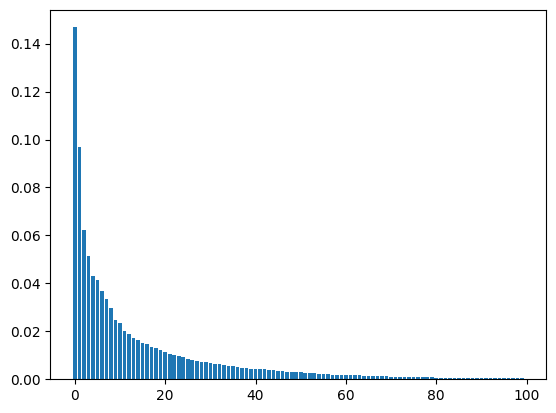

In [127]:
import matplotlib.pyplot as plt
plt.bar(x=range(100), height=model.explainedVariance)

In [128]:
cumvar=np.cumsum(model.explainedVariance)
cumvar

array([0.1468153 , 0.24372945, 0.30586305, 0.357454  , 0.40047843,
       0.44170816, 0.4786245 , 0.51190812, 0.54144511, 0.56598406,
       0.5893289 , 0.60965438, 0.62874515, 0.64582407, 0.66214815,
       0.67732954, 0.69203642, 0.70543947, 0.7185021 , 0.73056605,
       0.74189579, 0.7524079 , 0.76267648, 0.77225999, 0.7815438 ,
       0.78992854, 0.79803339, 0.80568287, 0.81308893, 0.8202753 ,
       0.82716301, 0.83360294, 0.83983382, 0.84563575, 0.85138043,
       0.85695304, 0.86223241, 0.86709865, 0.87173066, 0.87614906,
       0.8804042 , 0.88455717, 0.88868312, 0.89257098, 0.8962656 ,
       0.89979882, 0.90319528, 0.90642671, 0.90952191, 0.91246454,
       0.91531811, 0.91809844, 0.92071413, 0.92316584, 0.92546758,
       0.92768296, 0.92969908, 0.93162611, 0.93345925, 0.93524052,
       0.93693874, 0.93859715, 0.94019989, 0.94179115, 0.94332535,
       0.94477556, 0.94606821, 0.94734257, 0.94858844, 0.94976046,
       0.95087169, 0.95196062, 0.95298827, 0.95398285, 0.95492

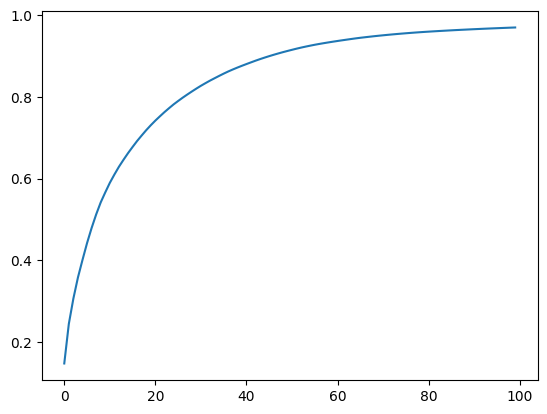

In [129]:
plt.plot(range(100),cumvar)